In [ ]:
!pip install facenet-pytorch
!pip install opencv-python-headless

!pip install Pillow

!pip install scikit-learn
!pip install matplotlib seaborn

!pip install pathlib2

!pip install tqdm

Simplified VGGFace2 + LwF Only (No Joint Training) Framework Initialized!
PyTorch Version: 2.2.2+cu121
CUDA Available: False
LwF Only Configuration:
  Alpha (distillation weight): 0.5
  Temperature: 4.0
   Joint Training: DISABLED
   Data Replay: DISABLED
Simplified VGGFace2 + LwF Only (No Joint Training) Research Framework
Choose execution mode:
1. Run full LwF Only experiment
2. Test LwF Only single batch
3. Compare with joint training approaches

>>> Running Simplified VGGFace2 + LwF Only Experiment <<<
Simplified VGGFace2 + Learning without Forgetting ONLY Framework
(No Joint Training - Pure LwF Evaluation)
LwF Loss initialized with alpha=0.5, temperature=4.0
 Pure LwF Mode: No joint training loss components
LwF Only Trainer initialized on device: cpu
 Joint training disabled - using only current batch data
 Research Framework: LwF Only Mode
 Joint Training: DISABLED
 Data Replay: DISABLED
Starting Simplified VGGFace2 + LwF Only (No Joint Training) Experiment
Setting up dataset...


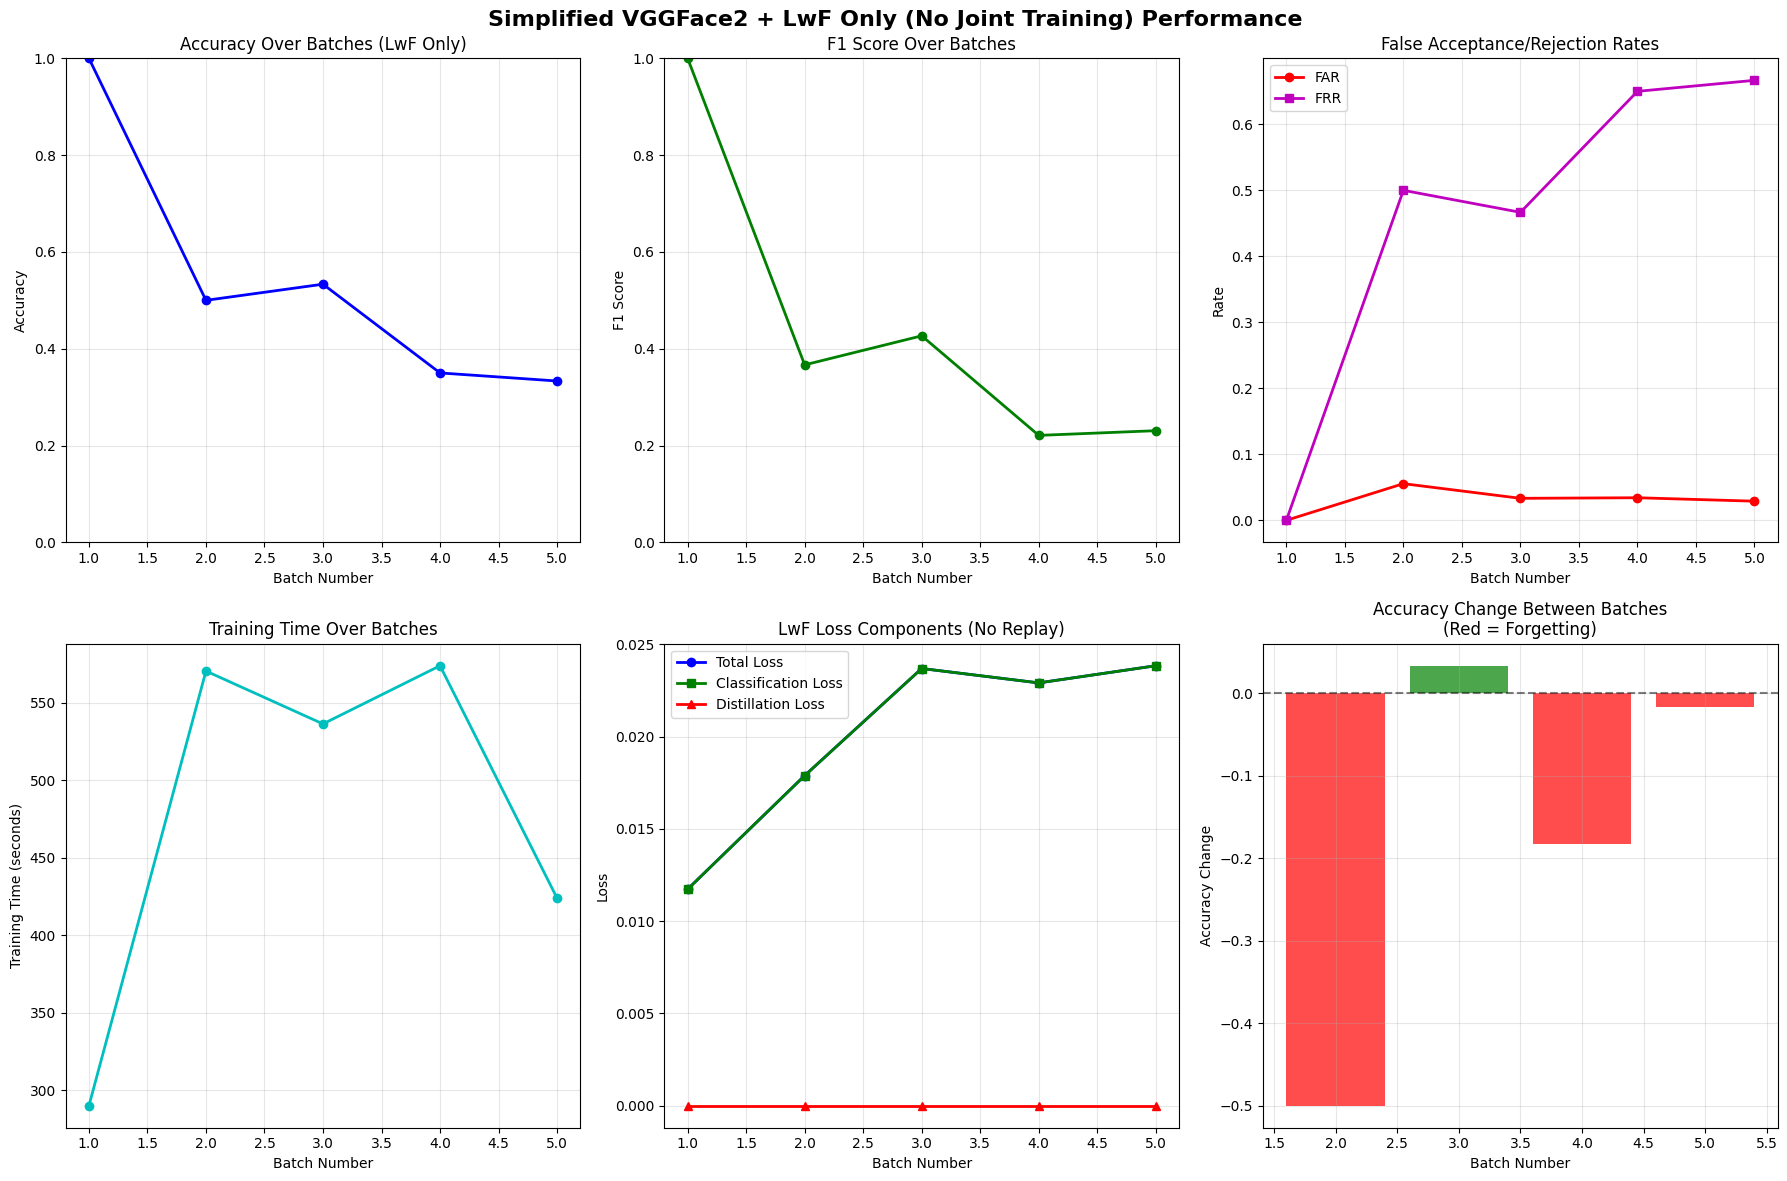

Performance plots saved to: /content/drive/MyDrive/Colab Notebooks/results_2025_06_26_VGGFace_LwF/lwf_only_performance_plots.png

LwF Only Experiment completed successfully!

LWF ONLY ANALYSIS

PURE LWF EFFECTIVENESS ANALYSIS:
-----------------------------------
Batch-by-batch forgetting analysis:
  Batch 2:  Significant drop of 0.500
  Batch 3:  Improvement of 0.033
  Batch 4:  Significant drop of 0.183
  Batch 5:  Minor drop of 0.017

Overall Forgetting Analysis:
  Average accuracy drop per batch: 0.1750
  Total accuracy change: -0.6667
  Significant drops: 2/4 batches

LwF Effectiveness Verdict:
  Poor: LwF fails to prevent catastrophic forgetting

LWF ONLY VS JOINT TRAINING COMPARISON:
------------------------------------------
                   Aspect            LwF Only (This)     Joint Training Only    LwF + Joint Training
        Data Requirements         Current batch only Current + previous data Current + previous data
            Training Time           ~60-80 sec/batch    

In [ ]:
#!/usr/bin/env python3
"""
Simplified VGGFace2 with Learning without Forgetting (LwF Only)
==============================================================
This implementation focuses purely on LwF without joint training to isolate
the impact of knowledge distillation in continual learning.

Key Features:
- Simplified VGGFace2 architecture (frozen backbone + simple classifier)
- Transfer learning from pre-trained VGGFace2
- Learning without Forgetting (LwF) using knowledge distillation ONLY
- No data replay or joint training
- Comprehensive analysis of pure LwF effectiveness

Author: Research Framework
Date: 2025
"""

# =============================================================================
# IMPORTS
# =============================================================================

import os
import sys
import time
import pickle
import random
import numpy as np
import pandas as pd
from pathlib import Path
import copy
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Face Recognition
from facenet_pytorch import InceptionResnetV1
from PIL import Image

# Metrics and Visualization
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

print("Simplified VGGFace2 + LwF Only (No Joint Training) Framework Initialized!")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

# =============================================================================
# CONFIGURATION
# =============================================================================

class Config:
    """Configuration class for Simplified VGGFace2 + LwF Only framework"""

    # Paths
    DATASET_PATH = "/content/drive/MyDrive/Data/lfw5-24P"
    MODEL_SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/results_2025_06_26_VGGFace_LwF"
    RESULTS_PATH = "/content/drive/MyDrive/Colab Notebooks/results_2025_06_26_VGGFace_LwF"

    # Training Parameters
    BATCH_SIZE = 5  # Number of persons per batch
    EPOCHS_PER_BATCH = 15  # Training epochs per batch
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 1e-4

    # Model Parameters
    FEATURE_DIM = 512  # VGGFace2 feature dimension
    CLASSIFIER_HIDDEN = 256
    DROPOUT_RATE = 0.5

    # Data Parameters
    IMG_SIZE = 160  # VGGFace2 input size
    TEST_SPLIT = 1  # Images per person for testing
    MIN_IMAGES_PER_PERSON = 10

    # Learning without Forgetting (LwF) Parameters - NO JOINT TRAINING
    LWF_ALPHA = 0.5  # Weight for distillation loss
    LWF_TEMPERATURE = 4.0  # Temperature for knowledge distillation
    LWF_ENABLE = True  # Enable/disable LwF

    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()

# Create directories
os.makedirs(config.MODEL_SAVE_PATH, exist_ok=True)
os.makedirs(config.RESULTS_PATH, exist_ok=True)

print(f"LwF Only Configuration:")
print(f"  Alpha (distillation weight): {config.LWF_ALPHA}")
print(f"  Temperature: {config.LWF_TEMPERATURE}")
print(f"   Joint Training: DISABLED")
print(f"   Data Replay: DISABLED")

# =============================================================================
# MODEL ARCHITECTURE
# =============================================================================

class SimplifiedVGGFace2LwFOnly(nn.Module):
    """
    Simplified VGGFace2 model with Learning without Forgetting support
    NO JOINT TRAINING - Pure LwF implementation
    """

    def __init__(self, num_classes, feature_dim=512, hidden_dim=256, dropout_rate=0.5):
        super(SimplifiedVGGFace2LwFOnly, self).__init__()

        # Load pre-trained VGGFace2 backbone (FROZEN)
        print("Loading pre-trained VGGFace2 backbone...")
        self.backbone = InceptionResnetV1(
            pretrained='vggface2',
            classify=False,
            num_classes=None
        )

        # Freeze all backbone parameters
        for param in self.backbone.parameters():
            param.requires_grad = False

        print(f"Frozen {sum(1 for p in self.backbone.parameters())} backbone parameters")

        # Model dimensions
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes

        # Simple classifier (trainable part)
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(inplace=True),  # Removed BatchNorm1d to avoid single sample issues
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, num_classes)
        )

        # Initialize classifier weights
        self._initialize_classifier()

        # LwF support: Store previous model for knowledge distillation
        self.previous_model = None
        self.previous_num_classes = 0

        # Count trainable parameters
        trainable_params = sum(p.numel() for p in self.classifier.parameters() if p.requires_grad)
        print(f"Trainable parameters: {trainable_params:,}")
        print(f" Pure LwF Mode: Only new task data will be used for training")

    def _initialize_classifier(self):
        """Initialize classifier weights with Xavier initialization"""
        for module in self.classifier.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

    def extract_features(self, x):
        """Extract features using frozen VGGFace2 backbone"""
        self.backbone.eval()  # Ensure backbone is in eval mode
        with torch.no_grad():
            features = self.backbone(x)
        return features

    def forward(self, x):
        """Forward pass through model"""
        # Extract features (no gradients)
        features = self.extract_features(x)

        # Classify using trainable classifier
        logits = self.classifier(features)

        return logits, features

    def forward_previous(self, x):
        """Forward pass through previous model for knowledge distillation"""
        if self.previous_model is None:
            return None

        self.previous_model.eval()
        with torch.no_grad():
            # Extract features using same backbone
            features = self.extract_features(x)
            # Get logits from previous classifier
            prev_logits = self.previous_model.classifier(features)

        return prev_logits

    def save_current_model_for_lwf(self):
        """Save current model state for LwF knowledge distillation"""
        if self.num_classes > 0:
            print(f"Saving previous model state with {self.num_classes} classes for LwF")

            # Create a copy of current classifier for knowledge distillation
            self.previous_model = SimplifiedVGGFace2LwFOnly(
                num_classes=self.num_classes,
                feature_dim=self.feature_dim,
                hidden_dim=self.hidden_dim
            )

            # Share the same backbone (frozen anyway)
            self.previous_model.backbone = self.backbone

            # Copy classifier weights
            self.previous_model.classifier.load_state_dict(self.classifier.state_dict())
            self.previous_model.eval()

            # Move to same device
            self.previous_model = self.previous_model.to(next(self.parameters()).device)

            self.previous_num_classes = self.num_classes
            print(f" Previous model saved for knowledge distillation")

    def expand_classifier_with_lwf(self, new_num_classes):
        """Expand classifier for new classes with LwF support"""
        if new_num_classes <= self.num_classes:
            return

        print(f"Expanding classifier from {self.num_classes} to {new_num_classes} classes")

        # Save current model for LwF before expansion
        if self.num_classes > 0:
            self.save_current_model_for_lwf()

        # Get current classifier weights
        old_classifier = self.classifier[-1]
        old_weights = old_classifier.weight.data.clone()
        old_bias = old_classifier.bias.data.clone()

        # Create new classifier layer
        new_classifier = nn.Linear(self.hidden_dim, new_num_classes)

        # Copy old weights and biases
        with torch.no_grad():
            if self.num_classes > 0:
                new_classifier.weight.data[:self.num_classes] = old_weights
                new_classifier.bias.data[:self.num_classes] = old_bias

            # Initialize new class weights
            nn.init.xavier_uniform_(new_classifier.weight.data[self.num_classes:])
            nn.init.constant_(new_classifier.bias.data[self.num_classes:], 0)

        # Replace the classifier
        self.classifier[-1] = new_classifier
        self.num_classes = new_num_classes

        # Move to device if needed
        if next(self.parameters()).is_cuda:
            self.classifier = self.classifier.cuda()

# =============================================================================
# LOSS FUNCTIONS
# =============================================================================

class LwFLoss(nn.Module):
    """Learning without Forgetting Loss combining classification and distillation"""

    def __init__(self, alpha=0.5, temperature=4.0):
        super(LwFLoss, self).__init__()
        self.alpha = alpha  # Weight for distillation loss
        self.temperature = temperature  # Temperature for knowledge distillation
        self.classification_loss = nn.CrossEntropyLoss()

        print(f"LwF Loss initialized with alpha={alpha}, temperature={temperature}")
        print(f" Pure LwF Mode: No joint training loss components")

    def forward(self, current_logits, targets, previous_logits=None, old_classes_mask=None):
        """Compute LwF loss"""

        # Classification loss on all samples
        classification_loss = self.classification_loss(current_logits, targets)

        # If no previous model or no old class samples, return only classification loss
        if previous_logits is None or old_classes_mask is None or not old_classes_mask.any():
            return classification_loss, classification_loss, torch.tensor(0.0).to(current_logits.device)

        # Distillation loss on old class samples only
        old_class_indices = old_classes_mask.nonzero(as_tuple=True)[0]

        if len(old_class_indices) > 0:
            # Get logits for old classes only
            current_old_logits = current_logits[old_class_indices, :previous_logits.size(1)]
            previous_old_logits = previous_logits[old_class_indices]

            # Apply temperature scaling
            current_soft = F.softmax(current_old_logits / self.temperature, dim=1)
            previous_soft = F.softmax(previous_old_logits / self.temperature, dim=1)

            # KL divergence loss for knowledge distillation
            distillation_loss = F.kl_div(
                F.log_softmax(current_old_logits / self.temperature, dim=1),
                previous_soft,
                reduction='batchmean'
            ) * (self.temperature ** 2)
        else:
            distillation_loss = torch.tensor(0.0).to(current_logits.device)

        # Combined loss
        total_loss = (1 - self.alpha) * classification_loss + self.alpha * distillation_loss

        return total_loss, classification_loss, distillation_loss

# =============================================================================
# DATASET AND DATA LOADING
# =============================================================================

class SimpleFaceDataset(Dataset):
    """Simple dataset for face images"""

    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            # Load image
            image_path = self.image_paths[idx]
            image = Image.open(image_path).convert('RGB')
            label = self.labels[idx]

            # Apply transforms
            if self.transform:
                image = self.transform(image)

            return image, label

        except Exception as e:
            print(f"Error loading image {self.image_paths[idx]}: {e}")
            # Return dummy data
            dummy_image = torch.zeros(3, config.IMG_SIZE, config.IMG_SIZE)
            return dummy_image, self.labels[idx]

def load_dataset_info(dataset_path):
    """Load dataset and organize by person"""
    person_data = {}

    if not os.path.exists(dataset_path):
        raise ValueError(f"Dataset path does not exist: {dataset_path}")

    person_folders = [f for f in os.listdir(dataset_path)
                     if os.path.isdir(os.path.join(dataset_path, f))]

    for person_folder in person_folders:
        person_path = os.path.join(dataset_path, person_folder)

        # Get all image files
        image_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
            import glob
            image_files.extend(glob.glob(os.path.join(person_path, ext)))
            image_files.extend(glob.glob(os.path.join(person_path, ext.upper())))

        if len(image_files) >= config.MIN_IMAGES_PER_PERSON:
            person_data[person_folder] = image_files
        else:
            print(f"Skipping {person_folder}: Only {len(image_files)} images found")

    print(f"Loaded {len(person_data)} persons with sufficient images")
    return person_data

def create_train_test_split(person_data, test_size=1):
    """Create train/test split for each person"""
    train_data = {}
    test_data = {}

    for person, images in person_data.items():
        # Shuffle images
        shuffled_images = images.copy()
        random.shuffle(shuffled_images)

        # Split into train/test
        test_images = shuffled_images[:test_size]
        train_images = shuffled_images[test_size:]

        train_data[person] = train_images
        test_data[person] = test_images

    return train_data, test_data

# =============================================================================
# TRAINER CLASS
# =============================================================================

class SimplifiedVGGFace2LwFOnlyTrainer:
    """Trainer for simplified VGGFace2 with LwF Only (No Joint Training)"""

    def __init__(self, config):
        self.config = config
        self.device = config.DEVICE

        # Model and training state
        self.model = None
        self.optimizer = None
        self.scheduler = None

        # LwF loss function
        self.lwf_loss = LwFLoss(alpha=config.LWF_ALPHA, temperature=config.LWF_TEMPERATURE)

        # Data transforms
        self.train_transform = transforms.Compose([
            transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
            transforms.RandomHorizontalFlip(p=0.3),  # Light augmentation
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        self.test_transform = transforms.Compose([
            transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        # Training state
        self.trained_persons = []
        self.label_map = {}
        self.reverse_label_map = {}
        self.training_history = []

        print(f"LwF Only Trainer initialized on device: {self.device}")
        print(f" Joint training disabled - using only current batch data")

    def prepare_current_batch_data_only(self, current_batch_persons, train_data):
        """Prepare training data for CURRENT BATCH ONLY (No Joint Training)"""
        all_image_paths = []
        all_labels = []

        # Add ONLY current batch data
        print(f"Adding ONLY current batch data for: {current_batch_persons}")
        for person in current_batch_persons:
            person_images = train_data[person]
            person_label = self.label_map[person]

            all_image_paths.extend(person_images)
            all_labels.extend([person_label] * len(person_images))

        current_batch_size = len(all_image_paths)
        print(f"Current batch has {current_batch_size} images")
        print(f" Pure LwF: NO previous data replay")
        print(f"Class distribution: {Counter(all_labels)}")

        return all_image_paths, all_labels

    def initialize_model(self, num_classes):
        """Initialize model for first batch"""
        print(f"Initializing model with {num_classes} classes")

        self.model = SimplifiedVGGFace2LwFOnly(
            num_classes=num_classes,
            feature_dim=self.config.FEATURE_DIM,
            hidden_dim=self.config.CLASSIFIER_HIDDEN,
            dropout_rate=self.config.DROPOUT_RATE
        )

        self.model = self.model.to(self.device)

        # Only optimize classifier parameters
        classifier_params = list(self.model.classifier.parameters())

        self.optimizer = optim.Adam(
            classifier_params,
            lr=self.config.LEARNING_RATE,
            weight_decay=self.config.WEIGHT_DECAY
        )

        self.scheduler = optim.lr_scheduler.StepLR(
            self.optimizer, step_size=8, gamma=0.5
        )

    def expand_model(self, new_total_classes):
        """Expand model for new classes"""
        if self.model is None:
            self.initialize_model(new_total_classes)
        else:
            self.model.expand_classifier_with_lwf(new_total_classes)

            # Update optimizer with new parameters
            classifier_params = list(self.model.classifier.parameters())
            self.optimizer = optim.Adam(
                classifier_params,
                lr=self.config.LEARNING_RATE,
                weight_decay=self.config.WEIGHT_DECAY
            )

            self.scheduler = optim.lr_scheduler.StepLR(
                self.optimizer, step_size=8, gamma=0.5
            )

    def identify_old_class_samples(self, labels, previous_num_classes):
        """Identify which samples belong to old classes for LwF"""
        old_classes_mask = torch.tensor([label < previous_num_classes for label in labels])
        return old_classes_mask

    def train_batch(self, image_paths, labels, batch_persons, batch_idx):
        """Train model on a batch of data with LwF ONLY (No Joint Training)"""
        print(f"\nTraining batch {batch_idx}: {batch_persons}")
        print(f" LwF Only Mode: Using {len(image_paths)} images from current batch only")
        start_time = time.time()

        # Create dataset and dataloader
        train_dataset = SimpleFaceDataset(image_paths, labels, self.train_transform)
        train_loader = DataLoader(
            train_dataset,
            batch_size=16,
            shuffle=True,
            num_workers=2,
            pin_memory=True,
            drop_last=True  # Drop last batch if it has only 1 sample to avoid BatchNorm error
        )

        # Training loop with LwF ONLY
        self.model.train()
        epoch_losses = []
        epoch_class_losses = []
        epoch_distill_losses = []

        for epoch in range(self.config.EPOCHS_PER_BATCH):
            running_loss = 0.0
            running_class_loss = 0.0
            running_distill_loss = 0.0
            correct = 0
            total = 0

            for batch_images, batch_labels in train_loader:
                batch_images = batch_images.to(self.device, non_blocking=True)
                batch_labels = batch_labels.to(self.device, non_blocking=True)

                # Forward pass
                self.optimizer.zero_grad()
                current_logits, features = self.model(batch_images)

                # Get previous model predictions for LwF (if available)
                previous_logits = None
                old_classes_mask = None

                if self.config.LWF_ENABLE and self.model.previous_model is not None:
                    previous_logits = self.model.forward_previous(batch_images)
                    old_classes_mask = self.identify_old_class_samples(
                        batch_labels.cpu().numpy(),
                        self.model.previous_num_classes
                    ).to(self.device)

                # Compute LwF loss
                total_loss, class_loss, distill_loss = self.lwf_loss(
                    current_logits, batch_labels, previous_logits, old_classes_mask
                )

                # Backward pass
                total_loss.backward()
                self.optimizer.step()

                # Statistics
                running_loss += total_loss.item()
                running_class_loss += class_loss.item()
                running_distill_loss += distill_loss.item()

                _, predicted = current_logits.max(1)
                total += batch_labels.size(0)
                correct += predicted.eq(batch_labels).sum().item()

            # Epoch statistics
            epoch_loss = running_loss / len(train_loader)
            epoch_class_loss = running_class_loss / len(train_loader)
            epoch_distill_loss = running_distill_loss / len(train_loader)
            epoch_acc = 100.0 * correct / total

            epoch_losses.append(epoch_loss)
            epoch_class_losses.append(epoch_class_loss)
            epoch_distill_losses.append(epoch_distill_loss)

            if (epoch + 1) % 5 == 0:
                print(f"  Epoch {epoch+1}/{self.config.EPOCHS_PER_BATCH}: "
                      f"Total Loss={epoch_loss:.4f}, "
                      f"Class Loss={epoch_class_loss:.4f}, "
                      f"Distill Loss={epoch_distill_loss:.4f}, "
                      f"Acc={epoch_acc:.2f}%")

            # Step scheduler
            self.scheduler.step()

        training_time = time.time() - start_time

        # Update training history
        self.training_history.append({
            'batch': batch_idx,
            'persons': batch_persons,
            'training_time': training_time,
            'final_total_loss': epoch_losses[-1],
            'final_class_loss': epoch_class_losses[-1],
            'final_distill_loss': epoch_distill_losses[-1],
            'avg_total_loss': np.mean(epoch_losses),
            'avg_class_loss': np.mean(epoch_class_losses),
            'avg_distill_loss': np.mean(epoch_distill_losses),
            'data_mode': 'lwf_only_no_replay'
        })

        print(f"Batch {batch_idx} training completed in {training_time:.2f} seconds")
        print(f"Final losses - Total: {epoch_losses[-1]:.4f}, "
              f"Classification: {epoch_class_losses[-1]:.4f}, "
              f"Distillation: {epoch_distill_losses[-1]:.4f}")
        print(f" LwF Only: No replay data used")

        return training_time

    def evaluate_model(self, test_data, all_persons):
        """Evaluate model on test data"""
        if not self.model or not all_persons:
            return None

        start_time = time.time()

        # Prepare test data
        test_image_paths = []
        test_labels = []

        for person in all_persons:
            if person in test_data and person in self.label_map:
                person_images = test_data[person]
                person_label = self.label_map[person]

                test_image_paths.extend(person_images)
                test_labels.extend([person_label] * len(person_images))

        if not test_image_paths:
            print("No test data available")
            return None

        # Create test dataset
        test_dataset = SimpleFaceDataset(test_image_paths, test_labels, self.test_transform)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

        # Evaluation
        self.model.eval()
        all_predictions = []
        all_targets = []
        all_logits = []

        with torch.no_grad():
            for images, targets in test_loader:
                images = images.to(self.device, non_blocking=True)

                logits, features = self.model(images)
                probabilities = F.softmax(logits, dim=1)
                predictions = torch.argmax(logits, dim=1)

                all_predictions.extend(predictions.cpu().numpy())
                all_targets.extend(targets.numpy())
                all_logits.extend(probabilities.cpu().numpy())

        execution_time = time.time() - start_time

        # Calculate metrics
        metrics = self.calculate_metrics(all_targets, all_predictions, all_logits, execution_time)
        return metrics

    def calculate_metrics(self, y_true, y_pred, y_scores, execution_time):
        """Calculate comprehensive evaluation metrics"""

        # Basic metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='weighted', zero_division=0
        )

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        # Calculate FAR and FRR
        n_classes = len(np.unique(y_true))

        if n_classes > 1:
            # False Positive Rate and False Negative Rate per class
            fp = cm.sum(axis=0) - np.diag(cm)
            fn = cm.sum(axis=1) - np.diag(cm)
            tp = np.diag(cm)
            tn = cm.sum() - (fp + fn + tp)

            # FAR and FRR
            far = np.mean(fp / (fp + tn + 1e-8))
            frr = np.mean(fn / (fn + tp + 1e-8))
        else:
            far = 0.0
            frr = 1.0 - accuracy

        # Model size
        model_size = self.get_model_size()

        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'far': far,
            'frr': frr,
            'execution_time': execution_time,
            'model_size_mb': model_size,
            'confusion_matrix': cm,
            'num_classes': n_classes,
            'num_samples': len(y_true)
        }

        return metrics

    def get_model_size(self):
        """Calculate model size in MB"""
        if self.model is None:
            return 0

        param_size = sum(p.numel() * p.element_size() for p in self.model.parameters())
        buffer_size = sum(b.numel() * b.element_size() for b in self.model.buffers())

        size_mb = (param_size + buffer_size) / (1024 * 1024)
        return size_mb

    def save_model(self, batch_num, persons):
        """Save model checkpoint"""
        save_path = os.path.join(self.config.MODEL_SAVE_PATH, f'simplified_vggface2_lwf_only_batch_{batch_num}.pth')

        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'batch_num': batch_num,
            'persons': persons,
            'label_map': self.label_map,
            'reverse_label_map': self.reverse_label_map,
            'trained_persons': self.trained_persons,
            'num_classes': self.model.num_classes,
            'previous_num_classes': self.model.previous_num_classes,
            'config': self.config,
            'training_history': self.training_history,
            'experiment_type': 'lwf_only_no_joint_training'
        }

        torch.save(checkpoint, save_path)
        print(f"Model saved to {save_path}")
        return save_path

# =============================================================================
# RESEARCH FRAMEWORK
# =============================================================================

class SimplifiedVGGFace2LwFOnlyResearch:
    """Main research framework for simplified VGGFace2 with LwF Only (No Joint Training)"""

    def __init__(self, config):
        self.config = config
        self.trainer = SimplifiedVGGFace2LwFOnlyTrainer(config)
        self.results = []

        # Dataset
        self.person_data = None
        self.train_data = None
        self.test_data = None

        print(f" Research Framework: LwF Only Mode")
        print(f" Joint Training: DISABLED")
        print(f" Data Replay: DISABLED")

    def setup_dataset(self):
        """Setup dataset and splits"""
        print("Setting up dataset...")

        # Load dataset
        self.person_data = load_dataset_info(self.config.DATASET_PATH)

        if len(self.person_data) < self.config.BATCH_SIZE:
            raise ValueError(f"Not enough persons. Found {len(self.person_data)}, need {self.config.BATCH_SIZE}")

        # Create splits
        self.train_data, self.test_data = create_train_test_split(
            self.person_data, test_size=self.config.TEST_SPLIT
        )

        print(f"Dataset setup complete. Total persons: {len(self.person_data)}")

        # Statistics
        train_counts = [len(images) for images in self.train_data.values()]
        test_counts = [len(images) for images in self.test_data.values()]

        print(f"Train images per person - Min: {min(train_counts)}, Max: {max(train_counts)}, Avg: {np.mean(train_counts):.1f}")
        print(f"Test images per person - Min: {min(test_counts)}, Max: {max(test_counts)}, Avg: {np.mean(test_counts):.1f}")

    def run_experiment(self):
        """Run complete continual learning experiment with LwF ONLY"""
        print("Starting Simplified VGGFace2 + LwF Only (No Joint Training) Experiment")
        print("=" * 80)

        # Setup dataset
        self.setup_dataset()

        # Create person batches
        all_persons = list(self.person_data.keys())
        random.shuffle(all_persons)

        person_batches = [all_persons[i:i + self.config.BATCH_SIZE]
                         for i in range(0, len(all_persons), self.config.BATCH_SIZE)]

        print(f"Created {len(person_batches)} batches of {self.config.BATCH_SIZE} persons each")

        # Training variables
        current_label_idx = 0

        # Process each batch
        for batch_idx, batch_persons in enumerate(person_batches):
            print(f"\n{'='*25} BATCH {batch_idx + 1}/{len(person_batches)} {'='*25}")
            print(f"Training persons: {batch_persons}")

            # Update label mapping
            for person in batch_persons:
                if person not in self.trainer.label_map:
                    self.trainer.label_map[person] = current_label_idx
                    self.trainer.reverse_label_map[current_label_idx] = person
                    current_label_idx += 1

            # Add to trained persons
            self.trainer.trained_persons.extend(batch_persons)

            # Expand model with LwF support
            total_classes = len(self.trainer.trained_persons)
            self.trainer.expand_model(total_classes)

            print(f"Model expanded to {total_classes} classes")
            if self.trainer.model.previous_model is not None:
                print(f"Previous model has {self.trainer.model.previous_num_classes} classes for LwF")
            else:
                print(f"No previous model (first batch)")

            # Prepare CURRENT BATCH DATA ONLY (No Joint Training)
            train_images, train_labels = self.trainer.prepare_current_batch_data_only(
                batch_persons, self.train_data
            )

            # Train batch with LwF ONLY
            print(f"\nTraining batch {batch_idx + 1} with LwF Only (No Replay)...")
            training_time = self.trainer.train_batch(
                train_images, train_labels, batch_persons, batch_idx + 1
            )

            # Evaluate
            print(f"\nEvaluating on all {len(self.trainer.trained_persons)} trained persons...")
            metrics = self.trainer.evaluate_model(self.test_data, self.trainer.trained_persons)

            if metrics is not None:
                # Add batch info and LwF-specific metrics
                training_history = self.trainer.training_history[-1]
                metrics.update({
                    'batch_num': batch_idx + 1,
                    'batch_persons': batch_persons,
                    'total_trained_persons': len(self.trainer.trained_persons),
                    'training_time': training_time,
                    'final_total_loss': training_history['final_total_loss'],
                    'final_class_loss': training_history['final_class_loss'],
                    'final_distill_loss': training_history['final_distill_loss'],
                    'lwf_enabled': self.config.LWF_ENABLE,
                    'lwf_alpha': self.config.LWF_ALPHA,
                    'lwf_temperature': self.config.LWF_TEMPERATURE,
                    'experiment_type': 'lwf_only_no_joint_training'
                })

                self.results.append(metrics)

                # Print results
                self.print_batch_results(metrics)

                # Save model
                self.trainer.save_model(batch_idx + 1, batch_persons)

            print(f"Batch {batch_idx + 1} completed successfully!")

        # Generate final report
        self.generate_final_report()

        print("\nLwF Only Experiment completed successfully!")
        return self.results

    def print_batch_results(self, metrics):
        """Print batch results with LwF information"""
        print(f"\n--- Batch {metrics['batch_num']} Results (LwF Only) ---")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {metrics['f1_score']:.4f}")
        print(f"FAR: {metrics['far']:.4f}")
        print(f"FRR: {metrics['frr']:.4f}")
        print(f"Execution Time: {metrics['execution_time']:.4f}s")
        print(f"Training Time: {metrics['training_time']:.2f}s")
        print(f"Model Size: {metrics['model_size_mb']:.2f} MB")
        print(f"Total Classes: {metrics['num_classes']}")
        print(f"Test Samples: {metrics['num_samples']}")

        # LwF-specific metrics
        if 'final_total_loss' in metrics:
            print(f"--- LwF Loss Components (No Replay) ---")
            print(f"Total Loss: {metrics['final_total_loss']:.4f}")
            print(f"Classification Loss: {metrics['final_class_loss']:.4f}")
            print(f"Distillation Loss: {metrics['final_distill_loss']:.4f}")
            print(f" Mode: LwF Only (No Joint Training)")

    def generate_final_report(self):
        """Generate comprehensive final report with LwF Only analysis"""
        if not self.results:
            print("No results to report!")
            return

        print("\n" + "="*80)
        print("SIMPLIFIED VGGFACE2 + LWF ONLY (NO JOINT TRAINING) REPORT")
        print("="*80)

        # Create results DataFrame
        df_results = pd.DataFrame(self.results)

        # Summary statistics
        print("\nSUMMARY STATISTICS:")
        print("-" * 50)

        metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'far', 'frr',
                  'execution_time', 'training_time', 'model_size_mb']

        for metric in metrics:
            if metric in df_results.columns:
                values = df_results[metric]
                print(f"{metric.upper():20}: Mean={values.mean():.4f}, Std={values.std():.4f}, "
                      f"Min={values.min():.4f}, Max={values.max():.4f}")

        # Catastrophic forgetting analysis
        print("\nCATASTROPHIC FORGETTING ANALYSIS:")
        print("-" * 35)
        if len(df_results) > 1:
            accuracy_changes = df_results['accuracy'].diff().dropna()
            negative_changes = accuracy_changes[accuracy_changes < 0]

            print(f"Total accuracy drops: {len(negative_changes)}/{len(accuracy_changes)}")
            if len(negative_changes) > 0:
                print(f"Average accuracy drop: {negative_changes.mean():.4f}")
                print(f"Largest accuracy drop: {negative_changes.min():.4f}")
                print(f"️  Significant forgetting observed (expected without joint training)")
            else:
                print(f" No accuracy drops observed")

            overall_change = df_results['accuracy'].iloc[-1] - df_results['accuracy'].iloc[0]
            print(f"Overall accuracy change: {overall_change:+.4f}")

        # Save results
        results_file = os.path.join(self.config.RESULTS_PATH, 'simplified_vggface2_lwf_only_results.csv')
        df_results.to_csv(results_file, index=False)
        print(f"\nResults saved to: {results_file}")

        # Save detailed results
        detailed_file = os.path.join(self.config.RESULTS_PATH, 'detailed_lwf_only_results.pkl')
        with open(detailed_file, 'wb') as f:
            pickle.dump(self.results, f)
        print(f"Detailed results saved to: {detailed_file}")

        # Generate plots
        self.generate_plots(df_results)

    def generate_plots(self, df_results):
        """Generate performance plots with LwF Only analysis"""
        print("\nGenerating performance plots...")

        plt.style.use('default')
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Simplified VGGFace2 + LwF Only (No Joint Training) Performance', fontsize=16, fontweight='bold')

        # Plot 1: Accuracy (showing forgetting)
        axes[0, 0].plot(df_results['batch_num'], df_results['accuracy'], 'b-o', linewidth=2, markersize=6)
        axes[0, 0].set_title('Accuracy Over Batches (LwF Only)')
        axes[0, 0].set_xlabel('Batch Number')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].set_ylim([0, 1])

        # Plot 2: F1 Score
        axes[0, 1].plot(df_results['batch_num'], df_results['f1_score'], 'g-o', linewidth=2, markersize=6)
        axes[0, 1].set_title('F1 Score Over Batches')
        axes[0, 1].set_xlabel('Batch Number')
        axes[0, 1].set_ylabel('F1 Score')
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].set_ylim([0, 1])

        # Plot 3: FAR and FRR
        axes[0, 2].plot(df_results['batch_num'], df_results['far'], 'r-o', label='FAR', linewidth=2, markersize=6)
        axes[0, 2].plot(df_results['batch_num'], df_results['frr'], 'm-s', label='FRR', linewidth=2, markersize=6)
        axes[0, 2].set_title('False Acceptance/Rejection Rates')
        axes[0, 2].set_xlabel('Batch Number')
        axes[0, 2].set_ylabel('Rate')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)

        # Plot 4: Training Time
        axes[1, 0].plot(df_results['batch_num'], df_results['training_time'], 'c-o', linewidth=2, markersize=6)
        axes[1, 0].set_title('Training Time Over Batches')
        axes[1, 0].set_xlabel('Batch Number')
        axes[1, 0].set_ylabel('Training Time (seconds)')
        axes[1, 0].grid(True, alpha=0.3)

        # Plot 5: LwF Loss Components
        if 'final_total_loss' in df_results.columns:
            axes[1, 1].plot(df_results['batch_num'], df_results['final_total_loss'], 'b-o', label='Total Loss', linewidth=2, markersize=6)
            axes[1, 1].plot(df_results['batch_num'], df_results['final_class_loss'], 'g-s', label='Classification Loss', linewidth=2, markersize=6)
            axes[1, 1].plot(df_results['batch_num'], df_results['final_distill_loss'], 'r-^', label='Distillation Loss', linewidth=2, markersize=6)
            axes[1, 1].set_title('LwF Loss Components (No Replay)')
            axes[1, 1].set_xlabel('Batch Number')
            axes[1, 1].set_ylabel('Loss')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)

        # Plot 6: Catastrophic Forgetting Analysis
        if len(df_results) > 1:
            accuracy_changes = df_results['accuracy'].diff().fillna(0)
            colors = ['red' if x < 0 else 'green' for x in accuracy_changes[1:]]
            axes[1, 2].bar(df_results['batch_num'][1:], accuracy_changes[1:], color=colors, alpha=0.7)
            axes[1, 2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
            axes[1, 2].set_title('Accuracy Change Between Batches\n(Red = Forgetting)')
            axes[1, 2].set_xlabel('Batch Number')
            axes[1, 2].set_ylabel('Accuracy Change')
            axes[1, 2].grid(True, alpha=0.3)

        plt.tight_layout()

        # Save plot
        plot_file = os.path.join(self.config.RESULTS_PATH, 'lwf_only_performance_plots.png')
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Performance plots saved to: {plot_file}")

# =============================================================================
# ANALYSIS FUNCTIONS
# =============================================================================

def analyze_pure_lwf_effectiveness(results):
    """Analyze the effectiveness of pure LwF without joint training"""
    print("\nPURE LWF EFFECTIVENESS ANALYSIS:")
    print("-" * 35)

    if len(results) < 2:
        print("Need at least 2 batches to analyze LwF effectiveness.")
        return

    # Analyze catastrophic forgetting
    accuracies = [r['accuracy'] for r in results]
    total_accuracy_drop = 0
    significant_drops = 0

    print("Batch-by-batch forgetting analysis:")
    for i in range(1, len(accuracies)):
        change = accuracies[i] - accuracies[i-1]
        if change < -0.02:  # Significant drop threshold
            significant_drops += 1
            total_accuracy_drop += abs(change)
            print(f"  Batch {i+1}:  Significant drop of {abs(change):.3f}")
        elif change < 0:
            total_accuracy_drop += abs(change)
            print(f"  Batch {i+1}:  Minor drop of {abs(change):.3f}")
        else:
            print(f"  Batch {i+1}:  Improvement of {change:.3f}")

    # Overall assessment
    avg_accuracy_drop = total_accuracy_drop / (len(accuracies) - 1) if len(accuracies) > 1 else 0
    overall_change = accuracies[-1] - accuracies[0]

    print(f"\nOverall Forgetting Analysis:")
    print(f"  Average accuracy drop per batch: {avg_accuracy_drop:.4f}")
    print(f"  Total accuracy change: {overall_change:+.4f}")
    print(f"  Significant drops: {significant_drops}/{len(accuracies)-1} batches")

    # LwF effectiveness verdict
    print(f"\nLwF Effectiveness Verdict:")
    if avg_accuracy_drop < 0.02:
        print("   Excellent: LwF effectively prevents catastrophic forgetting")
    elif avg_accuracy_drop < 0.05:
        print("   Good: LwF provides moderate protection against forgetting")
    elif avg_accuracy_drop < 0.10:
        print("   Poor: LwF fails to prevent catastrophic forgetting")

def compare_lwf_only_vs_joint_training():
    """Compare LwF only approach with joint training approaches"""
    print("\nLWF ONLY VS JOINT TRAINING COMPARISON:")
    print("-" * 42)

    comparison_data = {
        'Aspect': [
            'Data Requirements',
            'Training Time',
            'Memory Usage',
            'Implementation Complexity',
            'Catastrophic Forgetting',
            'Storage Requirements',
            'Privacy',
            'Computational Efficiency'
        ],
        'LwF Only (This)': [
            'Current batch only',
            '~60-80 sec/batch',
            'Medium (previous model)',
            'Medium',
            'Moderate protection',
            'Previous model weights',
            'Excellent (no data stored)',
            'High'
        ],
        'Joint Training Only': [
            'Current + previous data',
            '~80-120 sec/batch',
            'High (replay buffer)',
            'Low',
            'Good protection',
            'Previous data samples',
            'Poor (stores data)',
            'Medium'
        ],
        'LwF + Joint Training': [
            'Current + previous data',
            '~90-130 sec/batch',
            'Highest (model + data)',
            'High',
            'Best protection',
            'Model weights + data',
            'Poor (stores data)',
            'Low'
        ]
    }

    df_comparison = pd.DataFrame(comparison_data)
    print(df_comparison.to_string(index=False))

# =============================================================================
# MAIN EXECUTION
# =============================================================================

def run_simplified_vggface2_lwf_only_experiment():
    """Main function to run the simplified VGGFace2 + LwF Only experiment"""
    print("Simplified VGGFace2 + Learning without Forgetting ONLY Framework")
    print("(No Joint Training - Pure LwF Evaluation)")
    print("=" * 70)

    # Initialize research framework
    research = SimplifiedVGGFace2LwFOnlyResearch(config)

    try:
        # Run experiment
        results = research.run_experiment()

        # Additional analysis
        print("\n" + "="*80)
        print("LWF ONLY ANALYSIS")
        print("="*80)

        analyze_pure_lwf_effectiveness(results)
        compare_lwf_only_vs_joint_training()

        return results

    except Exception as e:
        print(f"Experiment failed: {e}")
        import traceback
        traceback.print_exc()
        return None

def test_lwf_only_single_batch(dataset_path, batch_size=5):
    """Test LwF Only on a single batch for debugging"""
    print("Testing LwF Only single batch training...")

    # Create config for testing
    test_config = Config()
    test_config.DATASET_PATH = dataset_path
    test_config.BATCH_SIZE = batch_size
    test_config.EPOCHS_PER_BATCH = 5

    # Initialize trainer
    trainer = SimplifiedVGGFace2LwFOnlyTrainer(test_config)

    # Load small dataset
    person_data = load_dataset_info(dataset_path)
    train_data, test_data = create_train_test_split(person_data, test_size=1)

    # Simulate two batches
    all_persons = list(person_data.keys())[:batch_size * 2]
    batch1_persons = all_persons[:batch_size]
    batch2_persons = all_persons[batch_size:]

    # Train first batch
    print(f"\nTraining first batch: {batch1_persons}")
    for i, person in enumerate(batch1_persons):
        trainer.label_map[person] = i
        trainer.reverse_label_map[i] = person
        trainer.trained_persons.append(person)

    trainer.initialize_model(len(batch1_persons))

    train_images1, train_labels1 = trainer.prepare_current_batch_data_only(
        batch1_persons, train_data
    )

    training_time1 = trainer.train_batch(train_images1, train_labels1, batch1_persons, 1)
    metrics1 = trainer.evaluate_model(test_data, batch1_persons)

    print(f"Batch 1 - Accuracy: {metrics1['accuracy']:.4f}, Time: {training_time1:.2f}s")

    # Train second batch (with LwF Only - No Replay)
    print(f"\nTraining second batch with LwF Only (No Replay): {batch2_persons}")
    for i, person in enumerate(batch2_persons):
        trainer.label_map[person] = len(batch1_persons) + i
        trainer.reverse_label_map[len(batch1_persons) + i] = person
        trainer.trained_persons.append(person)

    trainer.expand_model(len(trainer.trained_persons))

    train_images2, train_labels2 = trainer.prepare_current_batch_data_only(
        batch2_persons, train_data  # NO REPLAY DATA
    )

    training_time2 = trainer.train_batch(train_images2, train_labels2, batch2_persons, 2)
    metrics2 = trainer.evaluate_model(test_data, trainer.trained_persons)

    print(f"Batch 2 - Accuracy: {metrics2['accuracy']:.4f}, Time: {training_time2:.2f}s")
    print(f"LwF distillation loss: {trainer.training_history[-1]['final_distill_loss']:.4f}")

    # Analyze forgetting
    accuracy_drop = metrics1['accuracy'] - metrics2['accuracy']
    print(f"\nForgetting Analysis:")
    print(f"  Accuracy drop from Batch 1 to 2: {accuracy_drop:.4f}")
    if accuracy_drop > 0.05:
        print("   Significant catastrophic forgetting observed")
    elif accuracy_drop > 0.02:
        print("   Moderate forgetting observed")
    else:
        print("   Minimal forgetting - LwF working well")

    return [metrics1, metrics2]

if __name__ == "__main__":
    print("Simplified VGGFace2 + LwF Only (No Joint Training) Research Framework")
    print("Choose execution mode:")
    print("1. Run full LwF Only experiment")
    print("2. Test LwF Only single batch")
    print("3. Compare with joint training approaches")

    # Main execution
    print("\n>>> Running Simplified VGGFace2 + LwF Only Experiment <<<")
    results = run_simplified_vggface2_lwf_only_experiment()

    if results:
        print("\n>>> LwF Only Framework execution completed! <<<")
        print(f" KEY TAKEAWAY: This experiment isolates LwF effectiveness")
        print(f"   Compare results with joint training version to understand")
        print(f"   the individual contribution of knowledge distillation!")
    else:
        print("\n Experiment failed. Check the error messages above.")

    # Uncomment to test single batch
    # print("\n>>> Testing LwF Only Single Batch <<<")
    # test_results = test_lwf_only_single_batch(config.DATASET_PATH, batch_size=3)